In [2]:
# Import the required libraries:
import warnings
warnings.filterwarnings("ignore")
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier
from utils import *

On a tenté de challenger les résultats du modèle de scoring «classique» précédemment présenté par différents **algorithmes de Machine Learning**. 

Il s’agit du RandomForestClassifier, DecisionTreeClassifier, LinearDiscriminantAnalysis, GradientBoostingClassifier,  KNeighborsClassifier, VotingClassifier et StackingClassifier.

Afin d’optimiser au maximum nos résultats, on a présenté des jeux de paramètres à un algorithme de sélection le **GridSearchCV** qui, par validation croisée, va choisir pour chaque classificateur les paramètres qui **maximisent l’AUC**.

In [48]:
utils.grid_search("RandomForestClassifier",  X_train, y_train )

RandomForestClassifier
------
L'opération a pris 65.78s
Les meilleurs paramètres sont: {'max_depth': 100, 'max_features': 3, 'n_estimators': 25}
Le meilleur score AUC est: 0.81


In [50]:
utils.grid_search("DecisionTreeClassifier",  X_train, y_train )

DecisionTreeClassifier
------
L'opération a pris 6.64s
Les meilleurs paramètres sont: {'max_depth': 4, 'max_features': 10}
Le meilleur score AUC est: 0.84


In [51]:
utils.grid_search("LinearDiscriminantAnalysis",  X_train, y_train )

LinearDiscriminantAnalysis
------
L'opération a pris 0.19s
Les meilleurs paramètres sont: {}
Le meilleur score AUC est: 0.88


In [52]:
utils.grid_search("GradientBoostingClassifier",  X_train, y_train )

GradientBoostingClassifier
------
L'opération a pris 8.29s
Les meilleurs paramètres sont: {'learning_rate': 0.2, 'max_depth': 1, 'n_estimators': 25}
Le meilleur score AUC est: 0.85


In [53]:
utils.grid_search("KNeighborsClassifier", X_train, y_train )

KNeighborsClassifier
------
L'opération a pris 2.92s
Les meilleurs paramètres sont: {'n_neighbors': 35}
Le meilleur score AUC est: 0.87


Après avoir sélectionné les meilleurs paramètres de chacun des classificateurs (permettant de maximiser l'AUC), on construit les modèles et on compare leurs performances.

In [55]:
def model_comp(model, X_train = X_train, y_train = y_train, 
          X_test = X_test, y_test = y_test, 
          smote = True, show_roc = True, show_conf_matrix = False, cut_off = 0.45, show_prc = False) : 
    
    b = re.findall(r"[A-Za-z0-9]+", str(model))
    #Appliquer le smote :
    if smote == True:
        print("SMOTE")
        print("--------")
        smote = SMOTE(random_state=42 , k_neighbors=15)
        X_train, y_train = smote.fit_resample(X_train, y_train)
        
    lr = model.fit(X_train, y_train)
    print("train score %.2f" %lr.score(X_train, y_train))
    print("--------")
    
    #Prédiction des y_pred:
    train_pred = lr.predict_proba(X_train)[:,1]
    test_pred = lr.predict_proba(X_test)[:,1]
    print("test score %.2f" %lr.score(X_test, y_test))
    
    print("--------")
    print("Cut-off : ", cut_off)
    
    # Affichage des métriques: accuracy, precision, recall, f1-score au seuil de 50% de confiance (standard)
    print("--------")
    print("classification_report\n")
    test_pred_b = (test_pred > cut_off).astype(bool)
    train_pred_b = (train_pred > cut_off).astype(bool)
    print(classification_report(y_test, test_pred_b))
    print("\n")

    train_pred_b = (train_pred > cut_off).astype(bool)
    
    #Affichage de la matrice de confusion:
    if show_conf_matrix == True : 
        print("Matrice de confusion\n")
        print(confusion_matrix(y_test, test_pred_b))
        print("--------")
    
    #Tracé de la courbe ROC avec l'AUC:
    fpr, tpr, _= roc_curve(y_test, test_pred)
    roc_auc = auc(fpr, tpr)
    fpr_, tpr_, _train= roc_curve(y_train, train_pred)
    roc_auc_ = auc(fpr_, tpr_)
    print("L'AUC est de %.2f" %roc_auc)
    print("--------")
    Gini = roc_auc * 2 - 1
    print('Gini: %.2f' % (Gini))
    print("--------")
    
    if show_roc == True:
        print('roc curve')
        
        plt.figure(figsize=(6,6))
        plt.xlim([-0.01, 1.00])
        plt.ylim([-0.01, 1.01])
        plt.plot(fpr, tpr, lw=3, label='roc curve - Test (auc = {:0.2f})'.format(roc_auc))
        #plt.plot(fpr_, tpr_, lw=3, label='roc curve - Train (auc = {:0.2f})'.format(roc_auc_))
        plt.xlabel('False Positive Rate', fontsize=16)
        plt.ylabel('True Positive Rate', fontsize=16)
        plt.title(b[0], fontsize=16)
        plt.legend(loc='lower right', fontsize=13)
        plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
        plt.axes().set_aspect('equal')
        plt.show()
        print("\n")
        
       
    precision, recall, thresholds = precision_recall_curve(y_test, test_pred)
    precision_, recall_, thresholds_ = precision_recall_curve(y_train, train_pred)
    
    closest_zero = np.argmin(np.abs(thresholds))
    closest_zero_p = precision[closest_zero]
    closest_zero_r = recall[closest_zero]
    
    closest_zero_ = np.argmin(np.abs(thresholds_))
    closest_zero_p_ = precision_[closest_zero_]
    closest_zero_r_ = recall_[closest_zero_]
    
    if show_prc == True : 
        
        print("precision_recall_curve")
        plt.figure(figsize = (6,6))
        plt.xlim([0.0, 1.01])
        plt.ylim([0.0, 1.01])
        plt.plot(precision, recall, label='prc - Test')
        #plt.plot(precision_, recall_, label='prc - Train')
        #plt.plot(closest_zero_p, closest_zero_r, 'o', markersize = 12, fillstyle = 'none', c='r', mew=3)
        #plt.plot(closest_zero_p_, closest_zero_r_, 'o', markersize = 12, fillstyle = 'none', c='r', mew=3)
        plt.xlabel('Precision', fontsize=16)
        plt.ylabel('Recall', fontsize=16)
        plt.axes().set_aspect('equal')
        plt.legend(loc='lower left', fontsize=13)
        plt.show()

    J = tpr - fpr
    ix = np.argmax(J)
    seuil_opt = thresholds[ix]
    
    J_ = tpr_ - fpr_
    ix_ = np.argmax(J_)
    seuil_opt_ = thresholds_[ix_]
    print('Meilleur cut-off test : %f' % (seuil_opt))
    print('Meilleur cut-off train : %f' % (seuil_opt_))
    
    return fpr, tpr, roc_auc

On applique cette fonction aux différents modèles:

### RandomForestClassifier:

SMOTE
--------
train score 1.00
--------
test score 0.85
--------
Cut-off :  0.45
--------
classification_report

              precision    recall  f1-score   support

           0       0.86      0.97      0.91       927
           1       0.82      0.44      0.57       265

    accuracy                           0.85      1192
   macro avg       0.84      0.71      0.74      1192
weighted avg       0.85      0.85      0.84      1192



L'AUC est de 0.92
--------
Gini: 0.84
--------
roc curve


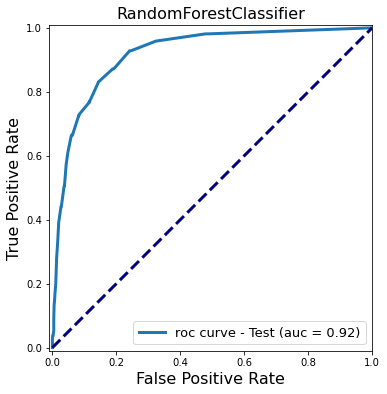



Meilleur cut-off test : 0.480000
Meilleur cut-off train : 0.600000


In [56]:
fpr_r, tpr_r, roc_auc_r = model_comp(model = RandomForestClassifier(max_depth=100, max_features=4, n_estimators = 25, random_state=42))

### DecisionTreeClassifier:

SMOTE
--------
train score 0.82
--------
test score 0.75
--------
Cut-off :  0.45
--------
classification_report

              precision    recall  f1-score   support

           0       0.84      0.83      0.83       927
           1       0.43      0.45      0.44       265

    accuracy                           0.74      1192
   macro avg       0.63      0.64      0.64      1192
weighted avg       0.75      0.74      0.75      1192



L'AUC est de 0.69
--------
Gini: 0.39
--------
roc curve


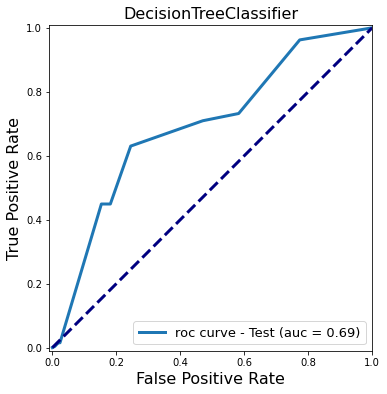



Meilleur cut-off test : 0.735849
Meilleur cut-off train : 0.481481


In [72]:
fpr_d, tpr_d, roc_auc_d = model_comp(model = DecisionTreeClassifier(max_depth=4, max_features=10))

### GradientBoostingClassifier:

SMOTE
--------
train score 0.82
--------
test score 0.81
--------
Cut-off :  0.45
--------
classification_report

              precision    recall  f1-score   support

           0       0.88      0.86      0.87       927
           1       0.54      0.59      0.57       265

    accuracy                           0.80      1192
   macro avg       0.71      0.72      0.72      1192
weighted avg       0.80      0.80      0.80      1192



L'AUC est de 0.82
--------
Gini: 0.64
--------
roc curve


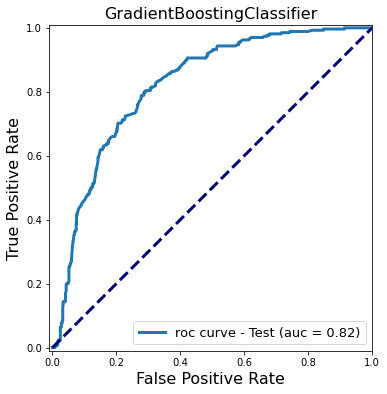



Meilleur cut-off test : 0.277165
Meilleur cut-off train : 0.331099


In [58]:
fpr_gb, tpr_gb, roc_auc_gb = model_comp(model = GradientBoostingClassifier(learning_rate=0.2, max_depth=1, n_estimators=25, random_state= 42))

### LinearDiscriminantAnalysis:

SMOTE
--------
train score 0.80
--------
test score 0.80
--------
Cut-off :  0.45
--------
classification_report

              precision    recall  f1-score   support

           0       0.93      0.78      0.85       927
           1       0.51      0.79      0.62       265

    accuracy                           0.78      1192
   macro avg       0.72      0.79      0.73      1192
weighted avg       0.84      0.78      0.80      1192



L'AUC est de 0.88
--------
Gini: 0.75
--------
roc curve


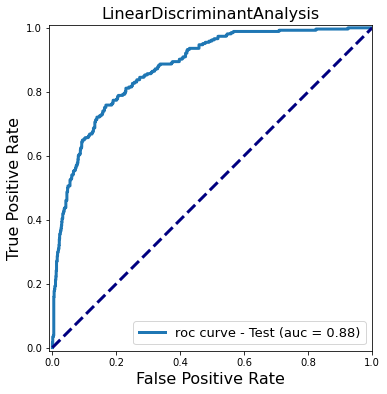



Meilleur cut-off test : 0.061381
Meilleur cut-off train : 0.091038


In [59]:
fpr_lda, tpr_lda, roc_auc_lda = model_comp(model = LinearDiscriminantAnalysis())

### KNeighborsClassifier:

SMOTE
--------
train score 0.84
--------
test score 0.78
--------
Cut-off :  0.45
--------
classification_report

              precision    recall  f1-score   support

           0       0.94      0.71      0.81       927
           1       0.46      0.85      0.59       265

    accuracy                           0.74      1192
   macro avg       0.70      0.78      0.70      1192
weighted avg       0.83      0.74      0.76      1192



L'AUC est de 0.87
--------
Gini: 0.75
--------
roc curve


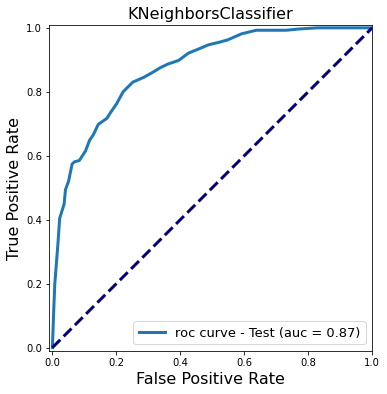



Meilleur cut-off test : 0.542857
Meilleur cut-off train : 0.514286


In [73]:
fpr_knn, tpr_knn, roc_auc_knn = model_comp(model = KNeighborsClassifier(n_neighbors=35))

On a décidé de comparer les performances des modèles précédents avec celles obtenues avec un VotingClassifier ou un StackingClassifier.

### VotingClassifier:

Il agrège les résultats de chaque classificateur et prédit la classe de sortie en fonction de la plus grande majorité des votes. 

SMOTE
--------
train score 0.92
--------
test score 0.87
--------
Cut-off :  0.45
--------
classification_report

              precision    recall  f1-score   support

           0       0.92      0.90      0.91       927
           1       0.68      0.71      0.69       265

    accuracy                           0.86      1192
   macro avg       0.80      0.81      0.80      1192
weighted avg       0.86      0.86      0.86      1192



L'AUC est de 0.90
--------
Gini: 0.79
--------
roc curve


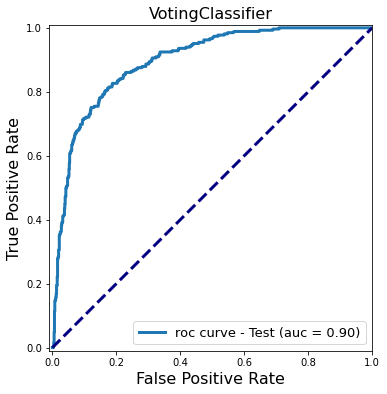



Meilleur cut-off test : 0.127919
Meilleur cut-off train : 0.178599


In [77]:
clf1 = KNeighborsClassifier(n_neighbors=35)
clf2 = RandomForestClassifier(max_depth=75, max_features=3, n_estimators = 25, random_state=42)
clf3 = LogisticRegression(penalty='l2', C=15, max_iter= 100, random_state=42)
clf4 = LinearDiscriminantAnalysis()
clf5 = DecisionTreeClassifier(max_depth=8, max_features=9)
clf6 = GradientBoostingClassifier(learning_rate=0.2, max_depth=5, n_estimators=25, random_state=2)


estimators=[('knn', clf1), ('rf', clf2), ('lr', clf3), ('lda', clf4), ('dt', clf5), ('gb', clf6)]

#VotingClassifier:
vclf = VotingClassifier(estimators, voting='soft')
fpr_vc, tpr_vc, roc_auc_vc = model_comp(model = vclf)

### StackingClassifier:

L’empilage est une technique d’apprentissage d’ensemble permettant de combiner plusieurs modèles de classification via un métaclassifieur. Ce dernier peut être entraîné sur les étiquettes de classe prédites ou sur les probabilités de l’ensemble.

On combine ainsi les algorithmes précédents et on affiche les performances du StackingClassifier:

SMOTE
--------
train score 1.00
--------
test score 0.84
--------
Cut-off :  0.45
--------
classification_report

              precision    recall  f1-score   support

           0       0.86      0.97      0.91       927
           1       0.83      0.46      0.59       265

    accuracy                           0.86      1192
   macro avg       0.85      0.72      0.75      1192
weighted avg       0.86      0.86      0.84      1192



L'AUC est de 0.93
--------
Gini: 0.85
--------
roc curve


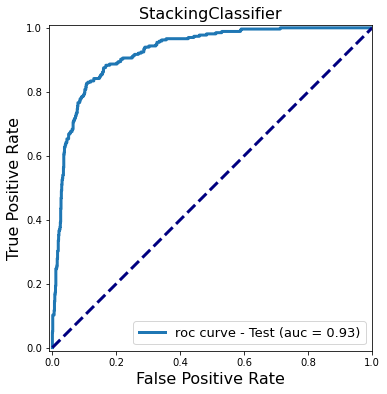



Meilleur cut-off test : 0.013508
Meilleur cut-off train : 0.068044


In [78]:
sclf = StackingClassifier(estimators)
fpr_sc, tpr_sc, roc_auc_sc = model_comp(model = sclf)

#### Courbe ROC de tous les algorithmes de Machine Learning testés:

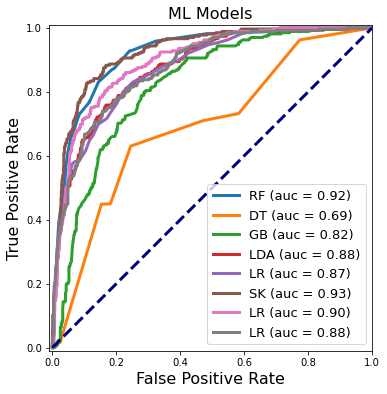

In [79]:
plt.figure(figsize=(6,6))
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
plt.plot(fpr_r, tpr_r, lw=3, label='RF (auc = {:0.2f})'.format(roc_auc_r))
plt.plot(fpr_d, tpr_d, lw=3, label='DT (auc = {:0.2f})'.format(roc_auc_d))
plt.plot(fpr_gb, tpr_gb, lw=3, label='GB (auc = {:0.2f})'.format(roc_auc_gb))
plt.plot(fpr_lda, tpr_lda, lw=3, label='LDA (auc = {:0.2f})'.format(roc_auc_lda))
plt.plot(fpr_knn, tpr_knn, lw=3, label='LR (auc = {:0.2f})'.format(roc_auc_knn))

plt.plot(fpr_sc, tpr_sc, lw=3, label='SK (auc = {:0.2f})'.format(roc_auc_sc))
plt.plot(fpr_vc, tpr_vc, lw=3, label='LR (auc = {:0.2f})'.format(roc_auc_vc))
plt.plot(fpr, tpr, lw=3, label='LR (auc = {:0.2f})'.format(roc_auc))

plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ML Models', fontsize=16)
plt.legend(loc='lower right', fontsize=13)
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
plt.axes().set_aspect('equal')
plt.show()

- On remarque que globalement le **RandomForestClassifier** donne des résultats très bons. Concernant l’AUC, il détient la pôle avec le **StackingClassifier**. 

- On voit que le **DecisionTreeClassifier** est le pire des algorithmes. Notre problème étant orienté recall, on se rend compte que ses performances comparées au **KNeighborsClassifier** ne sont pas très bonnes. 

- Le modèle le plus équilibré est le **VotingClassifier** qui présente le F1 score le plus élevé et son AUC est aussi appréciable. 

Toutefois, même si les algorithmes de ML se débrouillent pas mal, on préférera la logistique pour construire notre Grille de score en raison de son interprétabilité et de sa capacité à être facilement explicable.